<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/dataPreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


## Data Pre-Processing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


#### Load & Clean Data


In [18]:
df = pd.read_csv("time_series_60min_singleindex.csv")

# Define target column
target_col = "DE_load_actual_entsoe_transparency"

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]

# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()


# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time').ffill().bfill()

# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

#### Split Data (BEFORE SCALING)

In [19]:
# We define the split points using the raw data length
n = len(df)
train_size = int(n * 0.70)
val_size = int(n * 0.15)

# Split the raw DataFrame
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size : train_size + val_size]
test_df = df.iloc[train_size + val_size :]

print(f"Data Split: Train ({len(train_df)}), Val ({len(val_df)}), Test ({len(test_df)})")

Data Split: Train (35280), Val (7560), Test (7561)


##### Analysis and Visualization

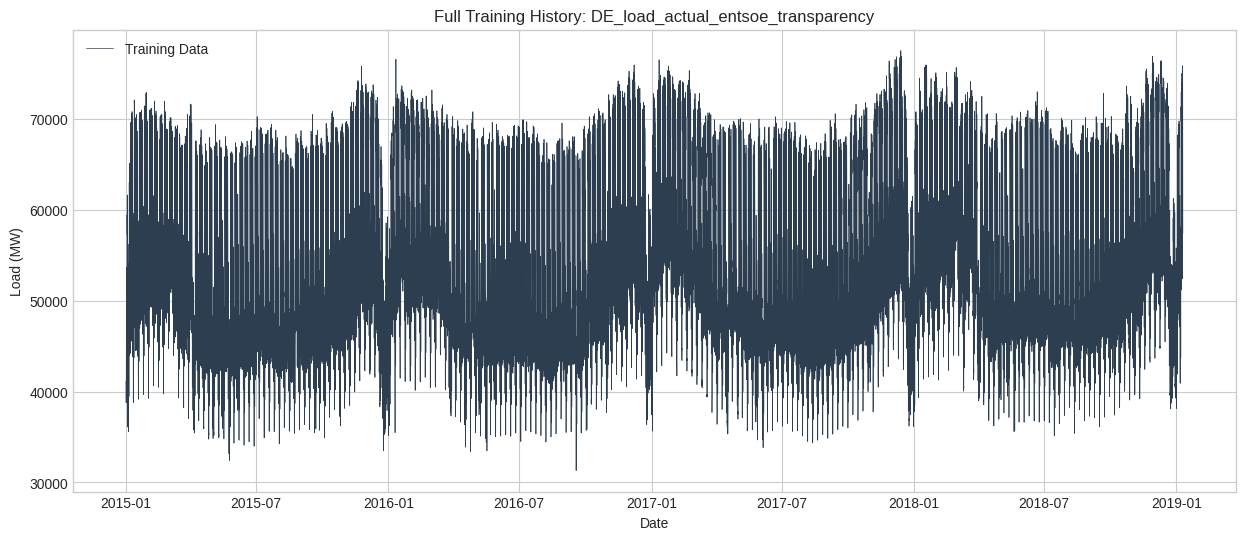

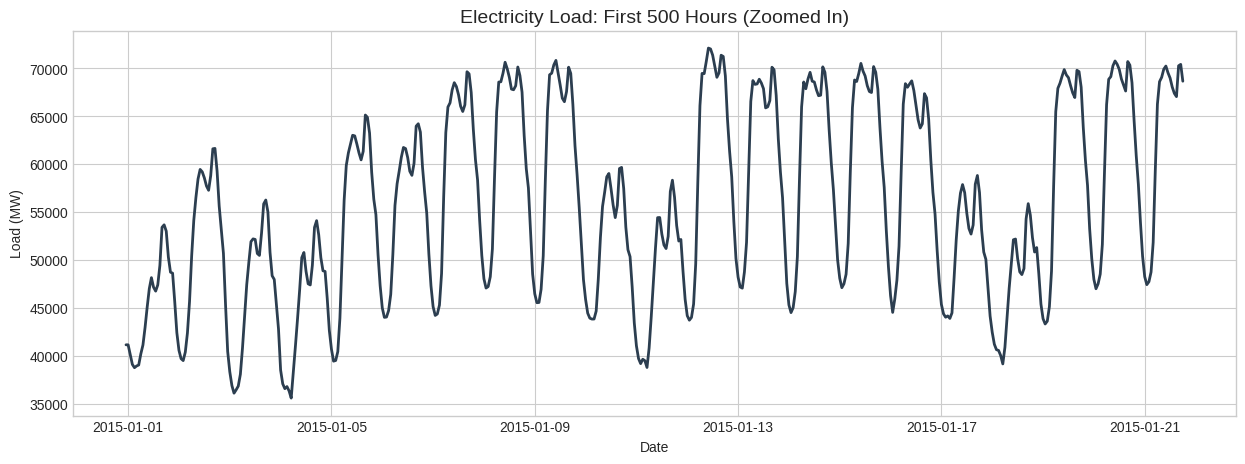

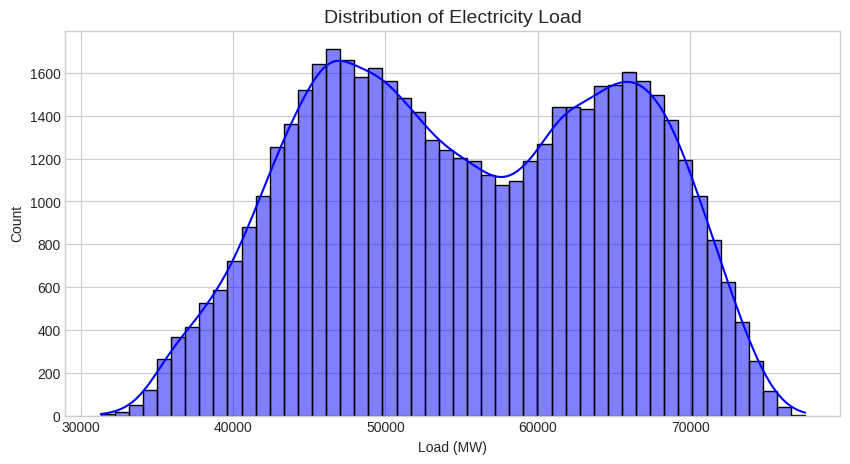

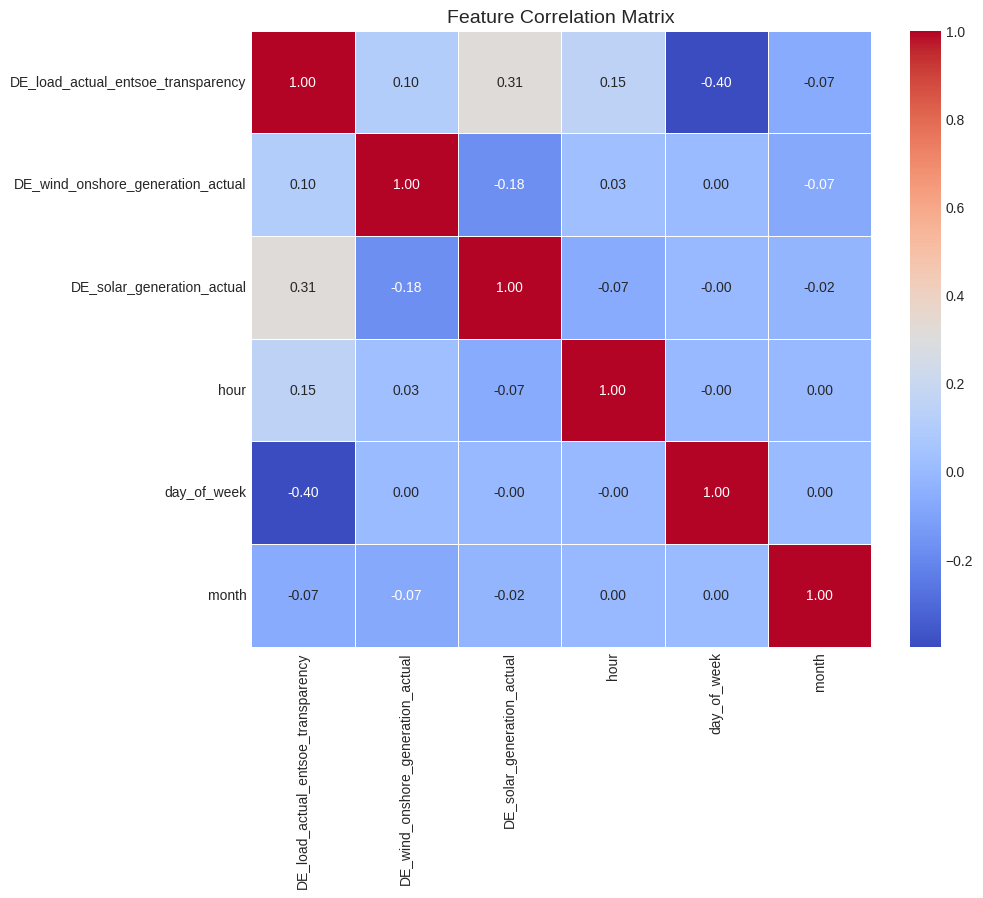

/tmp/ipython-input-3837349859.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")


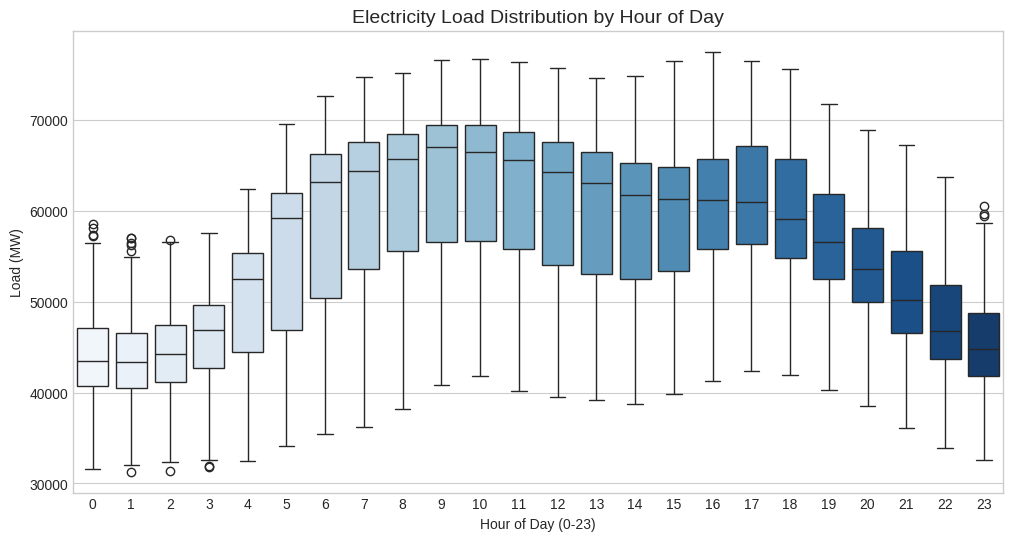


--- BEGINNING SEASONALITY ANALYSIS ---
Using Raw Training Data (in MW) for interpretability.



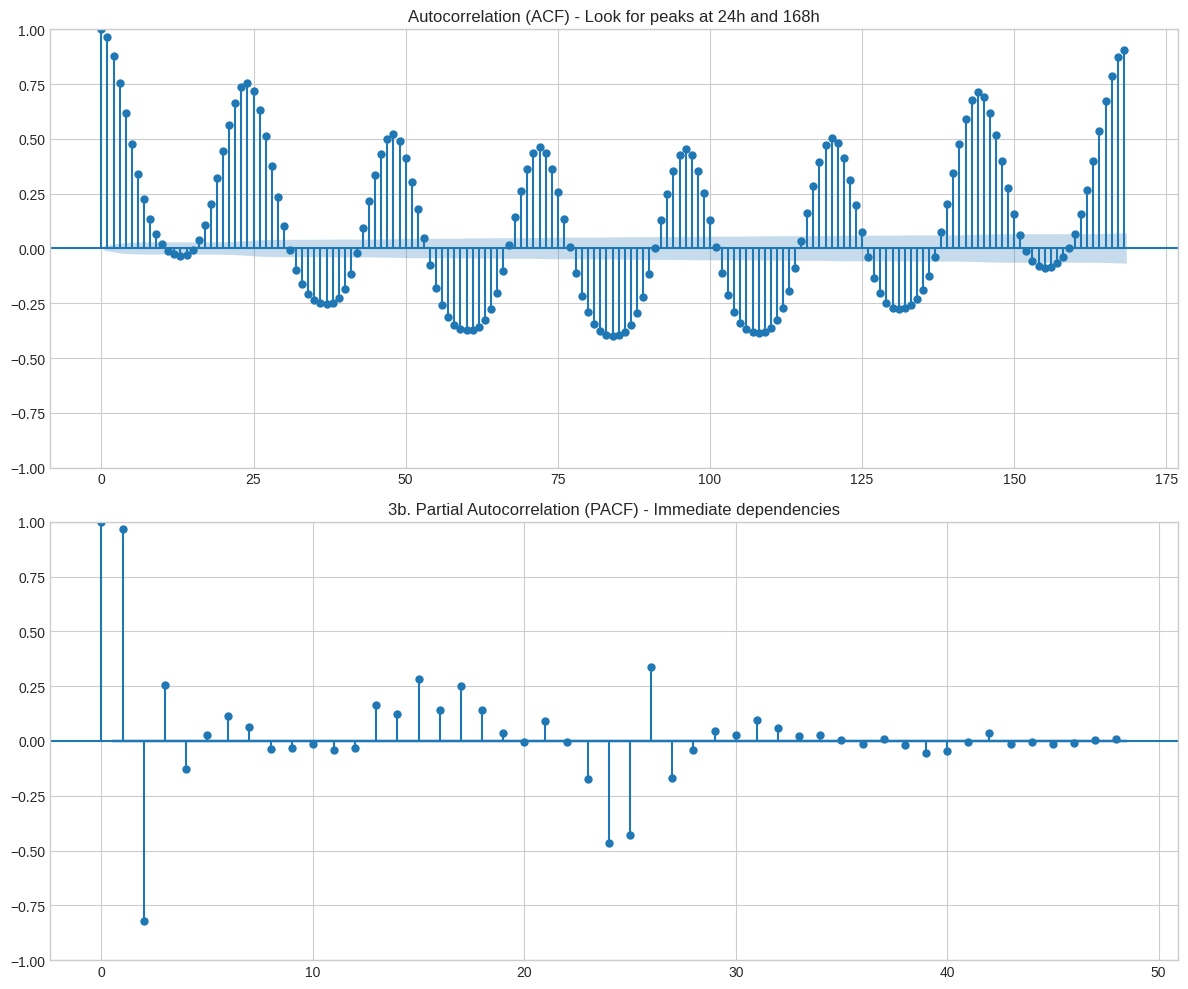

Generating Seasonal Decomposition...


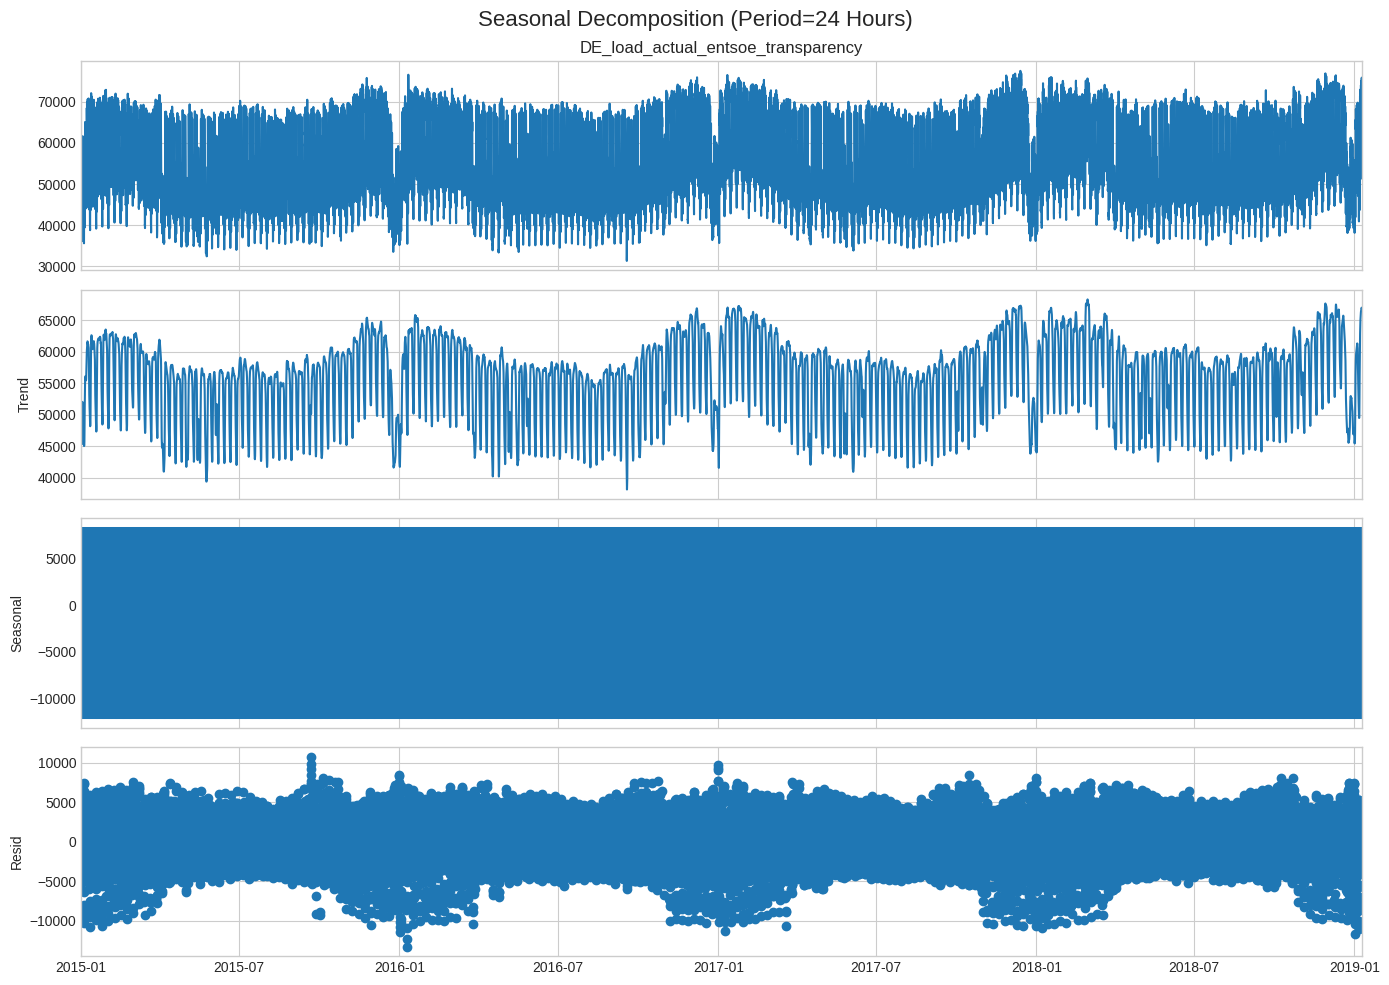


--- Augmented Dickey-Fuller Test Results ---
Test Statistic                   -22.872580
p-value                            0.000000
#Lags Used                        53.000000
Number of Observations Used    35226.000000
Critical Value (1%)               -3.430536
Critical Value (5%)               -2.861622
Critical Value (10%)              -2.566814
dtype: float64
Conclusion: Data is STATIONARY (Reject Null Hypothesis)


In [20]:
# Trend over full history
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df[target_col], label='Training Data', linewidth=0.5, color='#2c3e50')
plt.title(f'Full Training History: {target_col}')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

# Plot - Target Variable Over Time
plt.figure(figsize=(15, 5))
# Plot just the first 500 hours to make the pattern visible
plt.plot(df.index[:500], df['DE_load_actual_entsoe_transparency'][:500], color='#2c3e50', linewidth=2)
plt.title('Electricity Load: First 500 Hours (Zoomed In)', fontsize=14)
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.show()

# Distribution of the Target (Normality Check)
# Justifies using StandardScaler. If this looks like a Bell Curve, Standard Scaling is the mathematically correct choice.
plt.figure(figsize=(10, 5))
sns.histplot(df['DE_load_actual_entsoe_transparency'], kde=True, color='blue', bins=50)
plt.title('Distribution of Electricity Load', fontsize=14)
plt.xlabel('Load (MW)')
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
# Calculate correlation matrix
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

# Boxplot by Hour of Day
# Shows the "Shape" of a typical day.
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")
plt.title('Electricity Load Distribution by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Load (MW)')
plt.show()

# Seasonarity Analysis (on train data)
print("\n--- BEGINNING SEASONALITY ANALYSIS ---")
print("Using Raw Training Data (in MW) for interpretability.\n")

# ACF and PACF Plots
# We check for correlations up to 1 week (168 hours)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(train_df[target_col], lags=168, ax=ax1, title="Autocorrelation (ACF) - Look for peaks at 24h and 168h")
plot_pacf(train_df[target_col], lags=48, ax=ax2, method='ywm', title="3b. Partial Autocorrelation (PACF) - Immediate dependencies")

plt.tight_layout()
plt.show()

# Seasonal Decomposition
# We use period=24 to extract the Daily Cycle
print("Generating Seasonal Decomposition...")
decomposition = seasonal_decompose(train_df[target_col], model='additive', period=24)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Seasonal Decomposition (Period=24 Hours)', fontsize=16)
plt.tight_layout()
plt.show()

# Stationarity Test (ADF)
def adf_test(series):
    print(f"\n--- Augmented Dickey-Fuller Test Results ---")
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion: Data is STATIONARY (Reject Null Hypothesis)")
    else:
        print("Conclusion: Data is NON-STATIONARY (Fail to Reject Null Hypothesis)")
        print("Suggestion: Consider differencing if training accuracy is low.")

adf_test(train_df[target_col])

In [21]:
#Check for outliers to determine what type of Scaling we should use
# target column
data = df['DE_load_actual_entsoe_transparency']

# If Z-Score outliers are > 0%, MinMax scaling might squash our 'normal' data
# Any point more than 3 Standard Deviations from the mean is considered an outlier
mean = np.mean(data)
std = np.std(data)
z_scores = (data - mean) / std
outliers_z = np.sum(np.abs(z_scores) > 3)
pct_z = (outliers_z / len(data)) * 100

print(f"Total Data Points: {len(data)}")
print(f"Outliers (Z-Score > 3): {outliers_z} ({pct_z:.2f}%)")

Total Data Points: 50401
Outliers (Z-Score > 3): 0 (0.00%)


In [22]:
# SCALING (FIT ON TRAIN ONLY)
# Even though there are no outliers, we will use standard scalar to make the model
#robust for future unexpected outliers and to center the data for Relu activation function
scaler = StandardScaler()

# FIT only on Training data
scaler.fit(train_df)

# TRANSFORM all sets using the training statistics
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)


In [17]:
# CREATE WINDOWS
def create_sliding_windows(data, window_size, target_idx):
    X_list, y_list = [], []
    for i in range(len(data) - window_size):
        # Input: Past 'window_size' steps
        X_list.append(data[i : i + window_size])
        # Target: The very next step (at index i + window_size)
        y_list.append(data[i + window_size, target_idx])
    return np.array(X_list), np.array(y_list)

# Define params
WINDOW_SIZE = 24
TARGET_COL_NAME = "DE_load_actual_entsoe_transparency"
target_idx = df.columns.get_loc(TARGET_COL_NAME)

# Create sets
X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE, target_idx)
X_val, y_val = create_sliding_windows(val_scaled, WINDOW_SIZE, target_idx)
X_test, y_test = create_sliding_windows(test_scaled, WINDOW_SIZE, target_idx)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (35256, 24, 6)
Test shape:  (7537, 24, 6)
